#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [161]:
from __future__ import division
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as pl
import statsmodels.api as sm

import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are in MTA_Fare.npy

##note that the missing values are inputted as -1

we replace the -1 entries with NaN 

remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [162]:
mta = np.load('MTA_Fare.npy').astype(float)
mta.shape

(600, 23, 194)

In [163]:
for i in range(600):
    for j in range(23):
        for k in range(194):
            if mta[i][j][k] == -1:
                mta[i][j][k] = nan









#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

ride types list

In [164]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [165]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [166]:
date = pd.date_range(start='05/21/2010', end='02/21/2014', freq='W')
len(date)

196

In [167]:
#drop the first and the last data in date to make sure that it have dimension equal to the data set
date = date[1:-1]

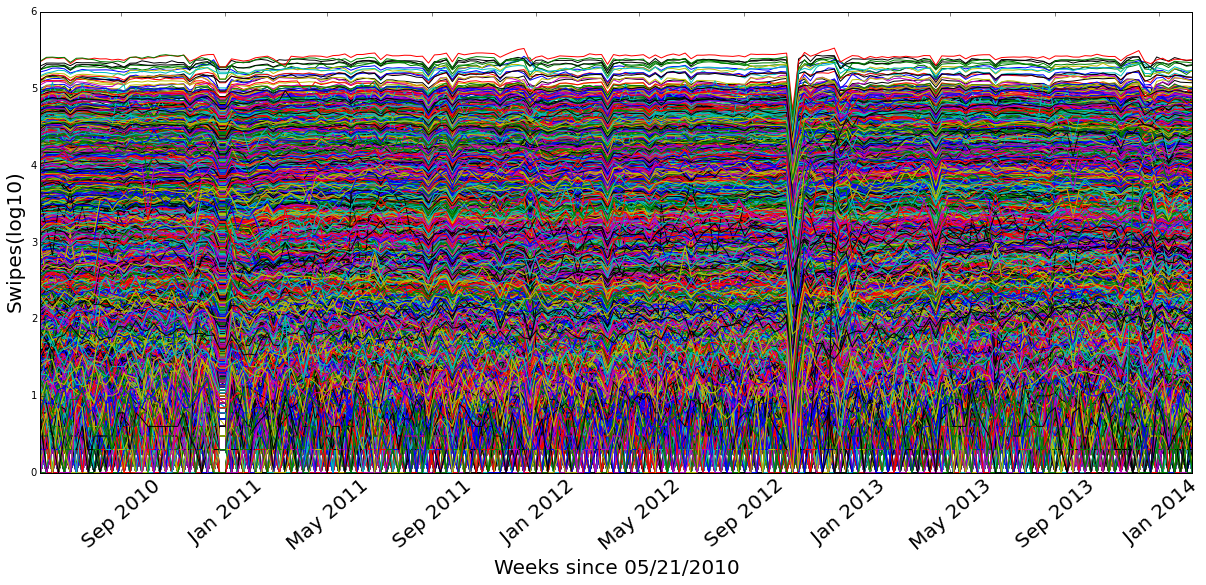

In [168]:
fig = figure(figsize=(20,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=20)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=40, fontsize=20)

for i in range(600):
        for j in range(23):
            plt.plot(date,np.log10(mta[i,j]))

In [169]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
mta_allsum1 = np.nansum(mta, axis=0)
mta_allsum = np.nansum(mta_allsum1, axis=0)

mta_allsum = pd.DataFrame(data=mta_allsum, index=date)

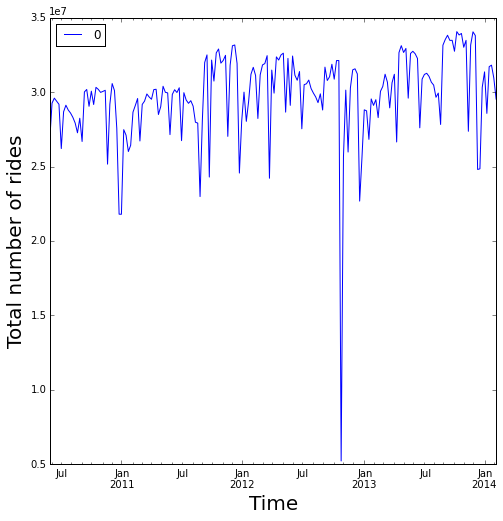

In [170]:
mta_allsum.plot(figsize=(8,8))

pl.ylabel("Total number of rides", fontsize=20)
pl.xlabel("Time", fontsize=20)

In [171]:
print mta_allsum.mean(), mta_allsum.std()
thresholds = [mta_allsum.mean() + 3*mta_allsum.std(), 
              mta_allsum.mean() - 3*mta_allsum.std()]
print thresholds


0    29781349.871134
dtype: float64 0    2991680.901414
dtype: float64
[0    38756392.575376
dtype: float64, 0    20806307.166892
dtype: float64]


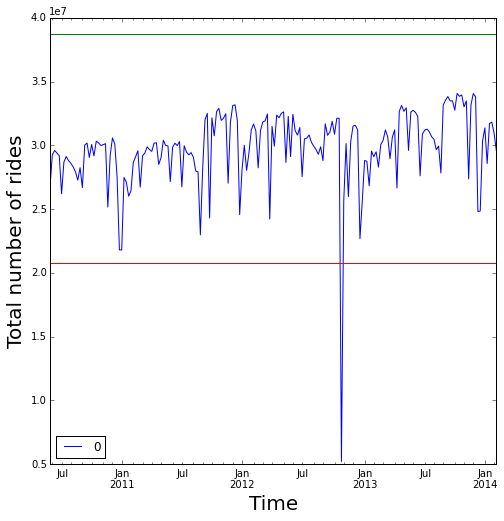

In [172]:
ax = mta_allsum.plot(figsize=(8,8))
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
pl.ylabel("Total number of rides", fontsize=20)
pl.xlabel("Time", fontsize=20)

In [173]:
thresholds

[0    38756392.575376
 dtype: float64, 0    20806307.166892
 dtype: float64]

In [174]:
mta_allsum.loc[(mta_allsum[0]<thresholds[1][0]) | (mta_allsum[0]>thresholds[0][0])]

,0
2012-10-28,5218686


### The sudden drop in MTA fare in Oct 28, 2012 through Nov 4, 2012 might be caused by the Hurricane Sandy.

# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [175]:
mta_allsta = pd.DataFrame(data=mta_allsum1.T, index=date)

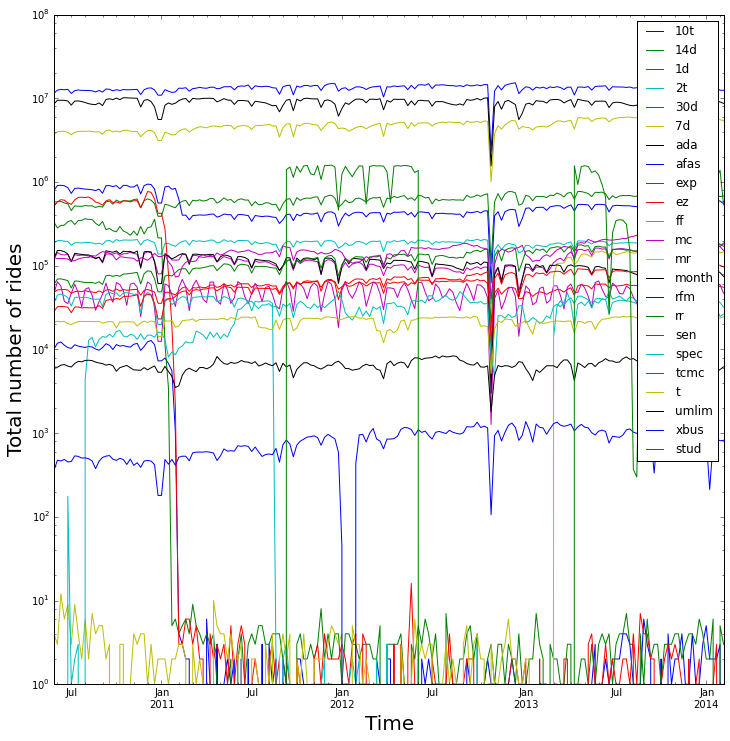

In [176]:
mta_allsta.plot(logy=True, figsize=(12,12))
plt.legend(ridetype)
pl.ylabel("Total number of rides", fontsize=20)
pl.xlabel("Time", fontsize=20)

## Calculate rolling mean to discover the increasing or decreasing trend for certain ridership types.

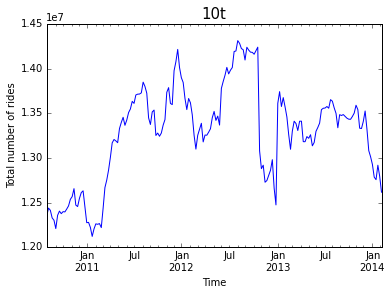

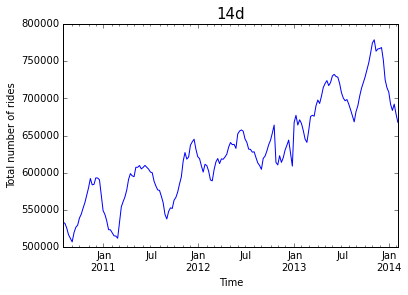

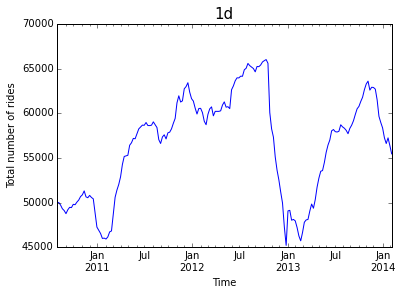

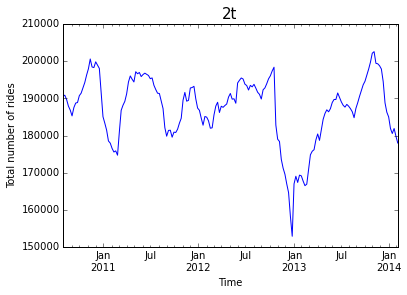

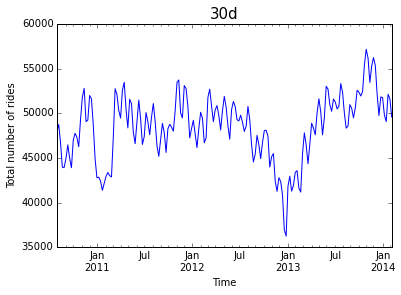

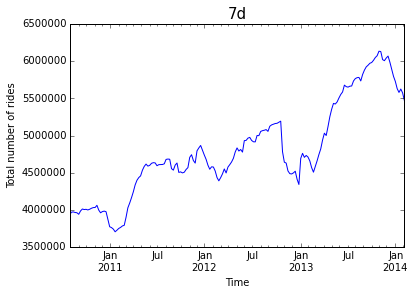

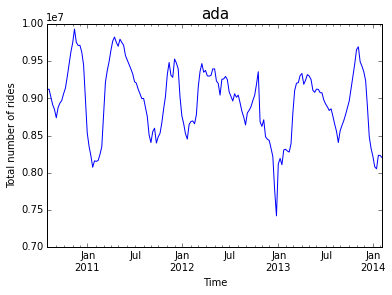

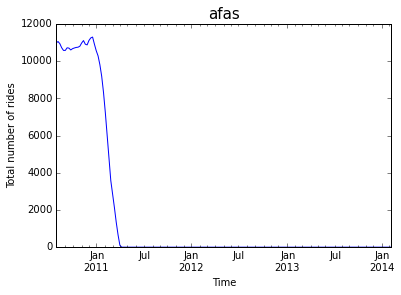

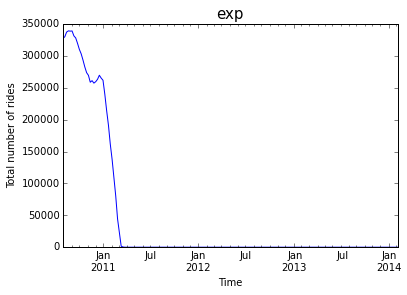

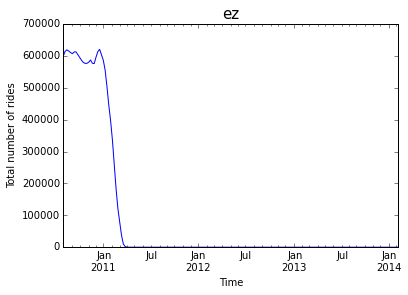

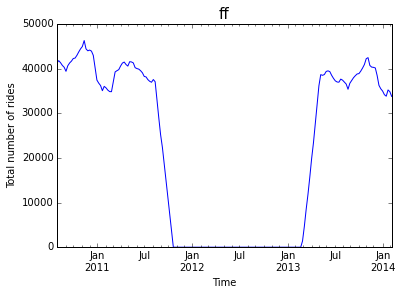

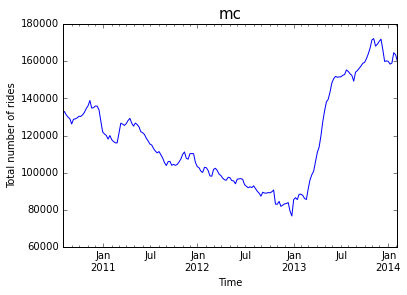

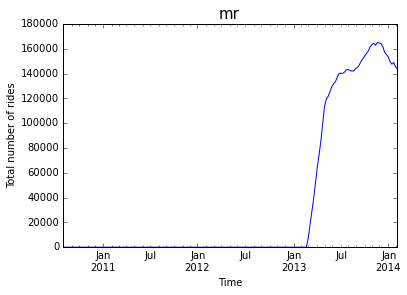

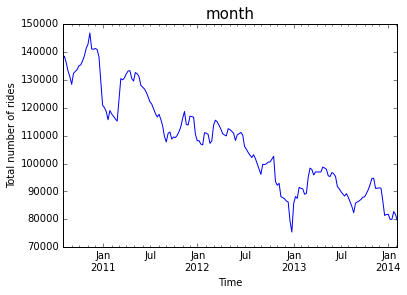

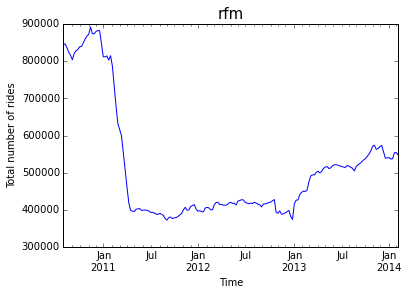

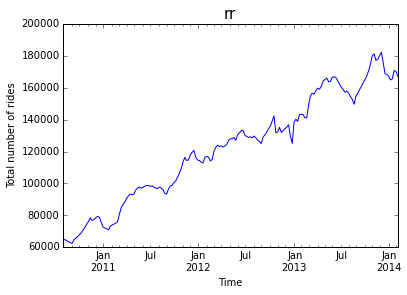

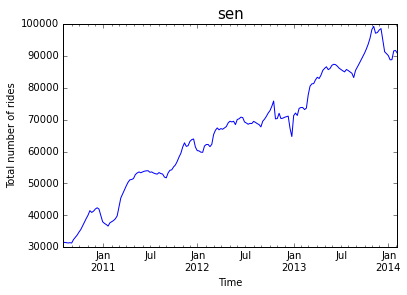

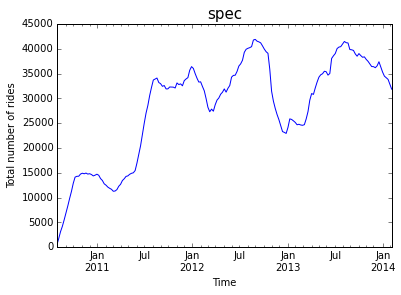

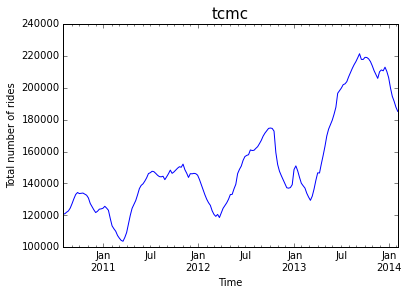

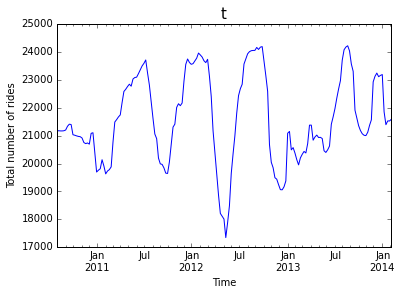

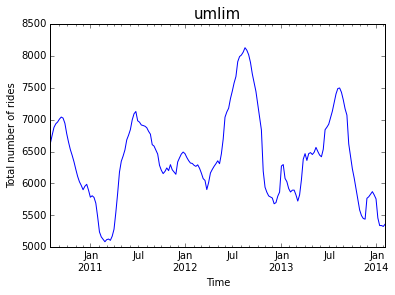

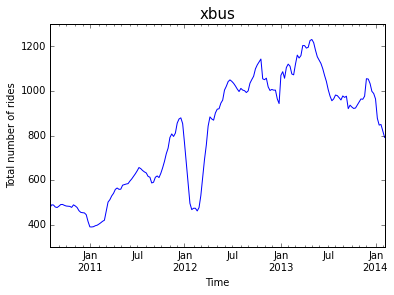

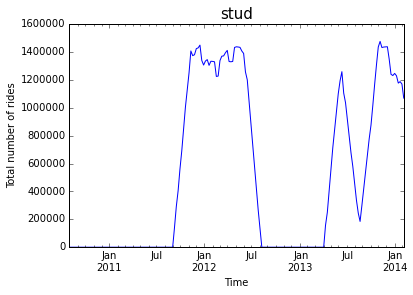

In [177]:
for i in range(23):
    ax = pd.rolling_mean(mta_allsta[i], 10).dropna().plot()
    ax.set_title(ridetype[i], fontsize=15)
    pl.ylabel("Total number of rides")
    pl.xlabel("Time")
    pl.figure()


### According to the plots above, we may conclude that:
The ridetypes with steadly increase in popularity are '14d','7d','rr','sen','spec','tcmc' and 'xbus'.

The ridetypes with steadly decrease in popularity are 'month'.

### Flux ratio

In [178]:
for i in range(23):
    first10 = pd.rolling_mean(mta_allsta[i].dropna(), 10)[9]
    last10  = pd.rolling_mean(mta_allsta[i].dropna(), 10)[-1]
    ratio   = first10 / last10
    print 'For the ridetype', ridetype[i], 'average usage in first 10 weeks and last 10 weeks are', first10\
    , 'and', last10, 'respectively, the flux ratio is', ratio

For the ridetype 10t average usage in first 10 weeks and last 10 weeks are 12347326.1 and 12616472.2 respectively, the flux ratio is 0.978667087302
For the ridetype 14d average usage in first 10 weeks and last 10 weeks are 533376.2 and 667821.7 respectively, the flux ratio is 0.79868054602
For the ridetype 1d average usage in first 10 weeks and last 10 weeks are 49898.9 and 55454.9 respectively, the flux ratio is 0.899810476622
For the ridetype 2t average usage in first 10 weeks and last 10 weeks are 190627.5 and 178008.6 respectively, the flux ratio is 1.07088927164
For the ridetype 30d average usage in first 10 weeks and last 10 weeks are 47956.2 and 49576.5 respectively, the flux ratio is 0.967317176485
For the ridetype 7d average usage in first 10 weeks and last 10 weeks are 3934303.6 and 5467689.0 respectively, the flux ratio is 0.719555117345
For the ridetype ada average usage in first 10 weeks and last 10 weeks are 9117571.2 and 8204367.5 respectively, the flux ratio is 1.111307

# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [179]:
mta_alltype = np.nansum(mta, axis=1)

## Power of stations by different periods

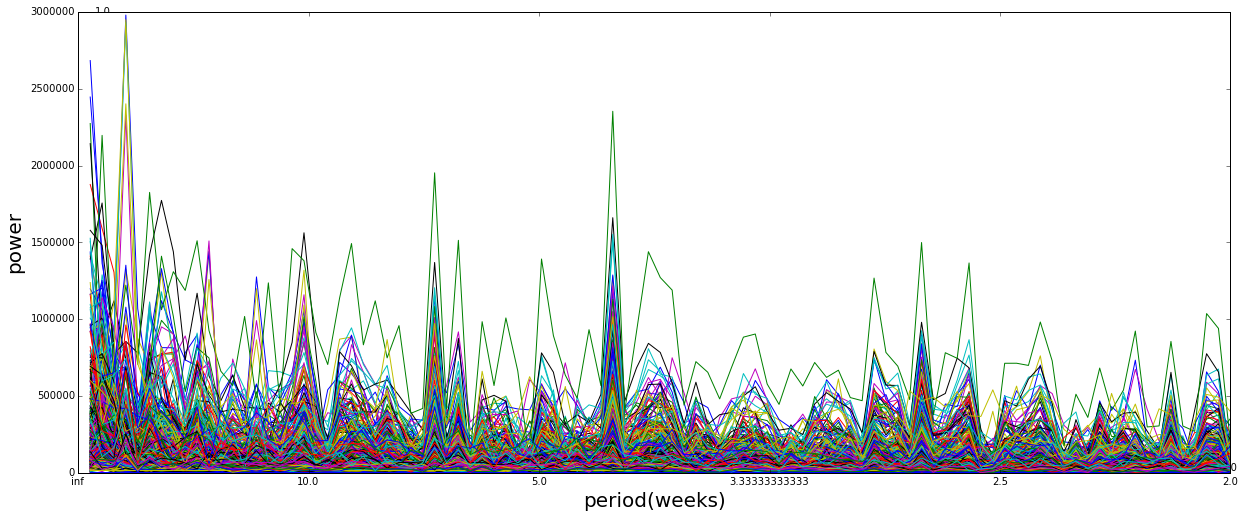

In [180]:
mta_eachsta = pd.DataFrame(mta_alltype)
fig = figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
pl.xlabel('period(weeks)', size=20)
pl.ylabel('power', size=20)

for i in range(mta_alltype.shape[0]):
    f = np.abs(np.fft.rfft(mta_alltype[i]))
    ax.plot(np.fft.rfftfreq(194,1.0)[1:],(f)[1:],'-',label = mta_eachsta.index[i])

    ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)

In [181]:
energy = []
for i in range(600):
    x = (np.abs(np.fft.rfft(mta_eachsta.T[i],)[1:]))
    energy.append(x[3])

In [182]:
sort(energy)[-1]

2980160.6355953491

In [183]:
print (np.where(energy==sort(energy)[-1])[0])
print (np.where(energy==sort(energy)[-2])[0])
print (np.where(energy==sort(energy)[-3])[0])
print (np.where(energy==sort(energy)[-4])[0])


[0]
[194]
[150]
[327]


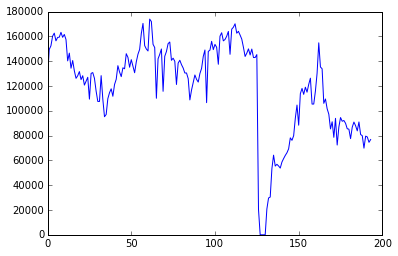

In [184]:
plot(mta_alltype[0])

### Station 0, 150, 194 and 327 have the most prominent annual periodicity.